<h1>Definitions</h1>
<h2> Species comparison sets (species sets)</h2>
We are comparing 4 species in all 10 possible combinations (6 pairs, 3 triplets, 1 quartet).

<h2> One-to-one (1:1) X orthologs</h2>
We want to make comparisons among 1:1 X orthologs in each species set, meaning genes that:
<pre>
    <b>1)</b> Exist in a <u>single copy on X within each species</u> in the comparison.
    <b>2)</b> Have <u>only one ortholog in each of the other species</u> in the comparison.
    <b>3)</b> Are <u>mutually the best orthology match</u> between/among species in the comparison.
</pre>

(See http://omabrowser.org/oma/type/ for more details on types of orthologs)


<h1>Raw ortholog data</h1>

Download ortholog data for all chrX genes in each species from Ensembl (http://www.ensembl.org/biomart).

For example, using <i>H. sapiens</i> GRCh38 as the reference...
<pre>
<b>Filters:</b>
    <b>Region:</b> Chromosome/scaffold=X
    <b>Attributes:</b>
        <b>Homologues:</b>
            <b>Gene:</b> Gene stable ID
            <b>Orthologues:</b> Dog gene stable ID
                         Dog chromosome/scaffold name
                         Dog homology type
                         Dog orthology confidence [0 low, 1 high]
                         Horse gene stable ID
                         Horse chromosome/scaffold name
                         Horse homology type
                         Horse orthology confidence [0 low, 1 high]
                         Mouse gene stable ID
                         Mouse chromosome/scaffold name
                         Mouse homology type
                         Mouse orthology confidence [0 low, 1 high]
                         Opossum gene stable ID
                         Opossum chromosome/scaffold name
                         Opossum homology type
                         Opossum orthology confidence [0 low, 1 high]
</pre>

Once all of the attributes are specified, click "Results" in the upper left hand corner and export all unique results to a .tsv file (will download as "mart_export.txt").

These files should be renamed between downloads so you don't overwrite them:
<pre>
     <b>Human:</b> GRCh38.p10 --> GRCh38_X_orthologs.txt
     <b>Mouse:</b> GRCm38.p5 --> GRCh38_X_orthologs.txt
     <b>Dog:</b> canFam3.1 --> canFam3.1_X_orthologs.txt
     <b>Horse:</b> equCab2 --> equCab2_X_orthologs.txt
     <b>Opossum:</b> monDom5 --> monDom5_X_orthologs.txt
<pre>


<h1>Generating 1:1 X ortholog lists for all species sets</h1>

<h2>Filtering X gene lists</h2>
For each comparison, we need to apply three filters to the reference species X gene list:
<pre>
<b>1) On X in all other species in set:</b>
    - Remove reference species X genes with non-X orthologs in one or more other species
<b>2) 1:1 orthology with all other species in set:</b>
    - Remove reference species X genes for which one or more other species has more than one ortholog
        (i.e. 1:many, many:1, many:many orthologs)
<b>3) High pairwise orthology confidence with all other species in set:</b>
    - Remove reference species X genes with low (0) orthology confidence in one or more other species
</pre>

This is all performed by the python function ortholog_sets():

In [27]:
import sys,re,os,itertools,functools
import pandas as pd

""" Function to collapse and filter lists of orthologs for all informative species comparisons in a given set of species."""

# Inputs: 1) Ref species ortholog file (1st col = all X genes for this species); 2) Comma separated list of ENSG ID prefixes for all species to be used in a comparison
# Output: For each species combo, a tab delimited file with rows = genes, cols = 1:1 ortholog IDs, and a data frame with the same information

def ortholog_sets(Ref_file, Species, Output_file):
    
    def species_sets(species):
        ''' Given a comma-delimited list of species names and number n, generate all species sets that include the ref species.'''
        # Input: Comma separated list of names for all species to be used in a comparison
        species = species.strip().split(',')
        ref_species = species[0]
        combos = []
        for n in range(1,len(species)+1):
            combos = combos+list(itertools.combinations(species,n))
        species_list = [i for i in combos if ref_species in i]
        return(species_list)
    
    def df_subset(full_df, set_species):
        ''' For a set of species, generate a data frame of ref genes with data in the other species. '''
        # Inputs: 1) The full data frame (all species);
        # 2) The names of the species to include in the smaller data frame
        header = full_df.columns
        keepcols = [0] # Keep reference gene column (col name = 'Gene Stable ID'; no species name)
        for col in header:
            col_species = col.split('_')[0] # Pull species name from column name
            if col_species in set_species:
                keepcols.append(header.get_loc(col))
        short_df = full_df[full_df.columns[keepcols]] # Generate a new data frame with only the relevant columns for this species pair
        final =  short_df.drop_duplicates(subset=None,keep='first',inplace=False) # Remove duplicate rows (leave 1) caused by multiple orthologs in one or more other species
        return(final)
    
    def df_filter(set_df,names):
        ''' For a set of species, retrieve confident 1:1 X orthologs. '''
        # Inputs: 1) Data frame with only relevant columns; 2) Species names for comparison
        
        def col_check(df, cols, val):
            ''' Apply a filter across all relevant columns of a data frame. '''
            # Inputs: 1) Data frame; 2) List of column names (to be filtered); 3) Filter value
            new_df = df
            for c in cols:
                new_df = new_df.loc[new_df[c] == val]
            return(new_df)
        
        # Make lists of columns (by name) that include relevant info for each filter
        gene_cols = [l for l in set_df.columns if re.search('ene_stable_ID',l)]
        chr_cols = [m for m in set_df.columns if re.search('chromosome',m)]
        homology_cols = [n for n in set_df.columns if re.search('homology',n)]
        orthology_cols = [p for p in set_df.columns if re.search('orthology', p)]
        
        # Keep only rows for which filter coditions are met 
        X = col_check(set_df,chr_cols,'X')
        X_one2one = col_check(X,homology_cols,'ortholog_one2one')
        X_one2one_conf = col_check(X_one2one,orthology_cols,1)
        
        # Remove homology, orthology, chromosome cols (keep only gene IDs)
        final_filt_df = X_one2one_conf[gene_cols]
        
        return(final_filt_df)
    
    
    # Parse inputs
    print('\nRef file:', Ref_file, 'Species to compare:', Species)
    
    # Make a data frame out of the Ref_file
    ref_df = pd.read_table(Ref_file,sep='\t')
    ref_df_clean = ref_df.fillna('NA') # replace NaNs with string 'NA'
    ref_df_clean.columns = [re.sub('\W','_',c) for c in ref_df_clean.columns] # replace spaces in column names with underscores
    
    # Generate a list of all possible subsets of the species being compared
    Species_sets = species_sets(Species)
    
    # Generate sub-data frame of confident 1:1 X orthologs for each species set
    all_cols = ref_df_clean.columns
    ortholog_dict = {}
    for s in Species_sets:
        s_sort = sorted(list(s)) # sort species names alphabetically
        s_name = '_'.join(s_sort)
        out = open(s_name+'_'+s[0]+'Ref.txt','w')
        set_df = df_subset(ref_df_clean,s)
        filt_set_df = df_filter(set_df,s_name)
        # Change ref column name to contain ref species name
        filt_set_df=filt_set_df.rename(columns = {'Gene_stable_ID':s[0]+'_gene_stable_ID'})
        # Sort columns by species name
        filt_set_df.sort_index(axis=1,inplace=True)
        # Sort rows by 1st column gene names so that dfs can easily be compared
        filt_set_df.sort_values(by=filt_set_df.columns[0],axis=0,inplace=True)
        ortholog_dict[s_name] = filt_set_df
        if len(s)==1:
            print(filt_set_df.shape[0],s_name,'input X genes')
        else:
            print(filt_set_df.shape[0],s_name,'confident 1:1 X orthologs')
        if re.match('y|Y|t|T',Output_file):
            filt_set_df.to_csv(out, sep='\t', index=False)
        
    return(ortholog_dict) # keys = species sets, values = ortholog dfs

In [28]:
# Create list to store dictionaries in
dict_list = []
# Using Human as ref species:
human_ortho_dict = ortholog_sets('GRCh38_X_orthologs.txt','Human,Dog,Mouse,Opossum','Y')
dict_list.append(human_ortho_dict)
# Using Mouse as ref species:
mouse_ortho_dict = ortholog_sets('GRCm38_X_orthologs.txt','Mouse,Dog,Human,Opossum','Y')
dict_list.append(mouse_ortho_dict)
# Using Opossum as ref species:
opossum_ortho_dict = ortholog_sets('MonDom5_X_orthologs.txt','Opossum,Dog,Human,Mouse','Y')
dict_list.append(opossum_ortho_dict)
# Using Dog as ref species:
dog_ortho_dict =ortholog_sets('CanFam3.1_X_orthologs.txt','Dog,Human,Mouse,Opossum','Y')
dict_list.append(dog_ortho_dict)


Ref file: GRCh38_X_orthologs.txt Species to compare: Human,Dog,Mouse,Opossum
2366 Human input X genes
511 Dog_Human confident 1:1 X orthologs
483 Human_Mouse confident 1:1 X orthologs
201 Human_Opossum confident 1:1 X orthologs
439 Dog_Human_Mouse confident 1:1 X orthologs
189 Dog_Human_Opossum confident 1:1 X orthologs
190 Human_Mouse_Opossum confident 1:1 X orthologs
179 Dog_Human_Mouse_Opossum confident 1:1 X orthologs

Ref file: GRCm38_X_orthologs.txt Species to compare: Mouse,Dog,Human,Opossum
2612 Mouse input X genes
459 Dog_Mouse confident 1:1 X orthologs
483 Human_Mouse confident 1:1 X orthologs
104 Mouse_Opossum confident 1:1 X orthologs
436 Dog_Human_Mouse confident 1:1 X orthologs
94 Dog_Mouse_Opossum confident 1:1 X orthologs
94 Human_Mouse_Opossum confident 1:1 X orthologs
88 Dog_Human_Mouse_Opossum confident 1:1 X orthologs

Ref file: MonDom5_X_orthologs.txt Species to compare: Opossum,Dog,Human,Mouse
727 Opossum input X genes
106 Dog_Opossum confident 1:1 X orthologs
20

<h2>Getting reciprocal lists of 1:1 X orthologs for species sets with n>2</h2>

We are making some assumptions about the data we got off the Ensembl database:
<pre>
    - All species' gene IDs are up to date within all species' orthology data
    - Orthology relationships are UTD and consistent across all species
</pre>

If these assumptions are met, the resulting gene lists should be reciprocal between compared species (given that using confident 1:1 orthologs should have already removed paralogs within each species), i.e. the human:mouse 1:1 X ortholog list should be the same whether it is generated from the human data or the mouse data.

Looking at the number above, this appears to be true for the pairwise combinations. However, with 3 or more species, the numbers differ depending on which species is used as the reference.

This is happening because the orthology confidence in a given reference file <u>only includes the orthology relationship between each species and the ref species</u>, e.g. for dog gene ENSCAFG00000011187:

<pre>
                Confidence Human ortholog ~ Mouse ortholog = 1
                Confidence Human ortholog ~ Dog ortholog = 1
                Confidence Mouse ortholog ~ Dog ortholog = 0
                
                Therefore ENSCAFG00000011187 is in Dog_Human_Mouse_HumanRef,
                but not Dog_Human_Mouse_DogRef or Dog_Human_Mouse_MouseRef
</pre>
I want gene lists where I can assume that genes in a trio or quartet are a subset of genes in a pair, e.g.
<pre>
        Human:Dog:Mouse ⊂ Human:Dog; Human:Mouse; Dog:Human; Dog:Mouse; Mouse:Human
        Human:Dog:Mouse:Opossum ⊂ Human:Dog:Mouse
        etc.
</pre>

So, I want gene lists such that each gene in each species has <u>orthology confidence = 1 across <i>all</i></u> species pairs in a set. The only way to get this information is to compare data for the same speces set generated from all reference files:

In [40]:
'''Get reciprocal 1:1 X ortholog lists for all species sets'''

from itertools import chain

# Get a list of unique species combos from the dictionaries assembled above
# ( dict_list = [Human_dict, Mouse_dict, Opossum_dict]
# for each dict: keys = species sets, values = ortholog dfs )
comparisons = set(chain.from_iterable([list(d.keys()) for d in dict_list]))

# For each comparison, get the intersection of reciprocal lists
# --> df in which all genes in each row are each other's 1:1 orthologs
venn_areas = {}
venn_genes = {}
for c in comparisons:
    comparison_dfs = []
    for d in dict_list:
        # Pull relevant data frames from all dictionaries
        if c in d.keys():
            comparison_dfs.append(d[c])
    # Merge all dfs in comparison_dfs and take the intersection of their rows
    reciprocal_orthologs = functools.reduce(lambda left,right: pd.merge(left,right,how='inner'), comparison_dfs)
    # Return as dictionaries of gene IDs, gene counts
    venn_genes[c] = reciprocal_orthologs
    venn_areas[c] = reciprocal_orthologs.shape[0]
    
    # Checked that this worked with Human_Mouse_Opossum:
    # ENSG00000029993 in Human_Mouse_Opossum_MouseRef (n=94) only,
    # ENSG00000130829 in Human_Mouse_Opossum_OpossumRef (n=94) only
    # --> Intersection n=93 as expected
    # (Also checked with Dog_Human_Mouse_Opossum)

#print(venn_genes.keys())    
    
venn_areas = pd.DataFrame(list(venn_areas.items()), columns=['Species','n_genes'])
print(venn_areas)

dict_keys(['Dog_Human', 'Human_Mouse_Opossum', 'Dog', 'Dog_Human_Mouse_Opossum', 'Human', 'Dog_Mouse', 'Human_Opossum', 'Opossum', 'Mouse', 'Human_Mouse', 'Dog_Human_Opossum', 'Mouse_Opossum', 'Dog_Opossum', 'Dog_Mouse_Opossum', 'Dog_Human_Mouse'])
                    Species  n_genes
0                 Dog_Human      511
1       Human_Mouse_Opossum       93
2                       Dog     1399
3   Dog_Human_Mouse_Opossum       77
4                     Human     2366
5                 Dog_Mouse      459
6             Human_Opossum      201
7                   Opossum      727
8                     Mouse     2612
9               Human_Mouse      483
10        Dog_Human_Opossum       95
11            Mouse_Opossum      104
12              Dog_Opossum      106
13        Dog_Mouse_Opossum       83
14          Dog_Human_Mouse      434


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


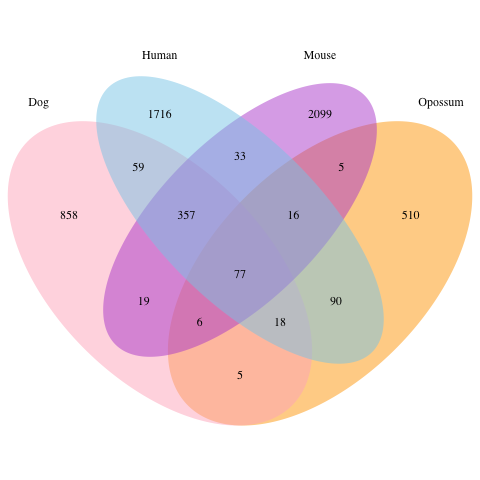

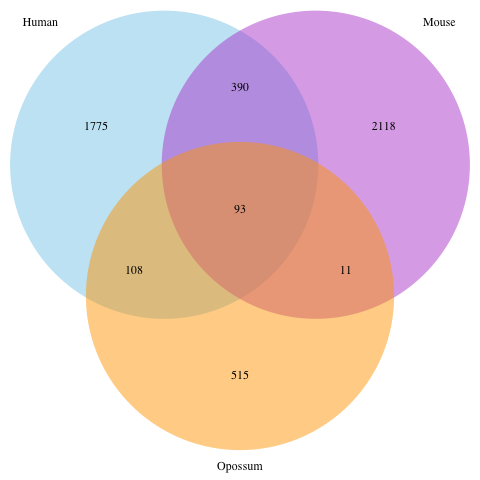

In [43]:
# Generate a Venn diagram of orthologs
# Based on https://rstudio-pubs-static.s3.amazonaws.com/13301_6641d73cfac741a59c0a851feb99e98b.html

%load_ext rpy2.ipython
%R library(VennDiagram)
%R draw.quad.venn(area1=1399,area2=727,area3=2366,area4=2612,n12=106,n13=511,n14=459,n23=201,n24=104,n34=483,n123=95,n124=83,n134=434,n234=93,n1234=77,category = c("Dog","Opossum","Human","Mouse"),lty="blank",fill=c("pink1","orange","skyblue","mediumorchid"));
%R draw.triple.venn(area1=2366,area2=2612,area3=727,n12=483,n23=104,n13=201,n123=93,category = c("Human","Mouse","Opossum"),lty="blank",fill=c("skyblue","mediumorchid","orange"));
